In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Let's see what all sports are there.

sports_list = os.listdir("/content/drive/MyDrive/MY_PROJECT/DL Project/sports-classification/train")

print(f"There are total {len(sports_list)} sports in this dataset!\n")

for i in range(0, 100, 4):
    print(f"{sports_list[i]:{20}}\t{sports_list[i+1]:{20}}\t{sports_list[i+2]:{20}}\t{sports_list[i+3]:{20}}")

There are total 100 sports in this dataset!

air hockey          	ampute football     	archery             	arm wrestling       
axe throwing        	balance beam        	barell racing       	baseball            
basketball          	baton twirling      	bike polo           	billiards           
bmx                 	bobsled             	bowling             	boxing              
bull riding         	bungee jumping      	canoe slamon        	cheerleading        
chuckwagon racing   	cricket             	croquet             	curling             
disc golf           	fencing             	field hockey        	figure skating men  
figure skating pairs	figure skating women	fly fishing         	football            
formula 1 racing    	frisbee             	gaga                	giant slalom        
golf                	hammer throw        	hang gliding        	harness racing      
high jump           	hockey              	horse jumping       	horse racing        
horseshoe pitching  	hurdles   

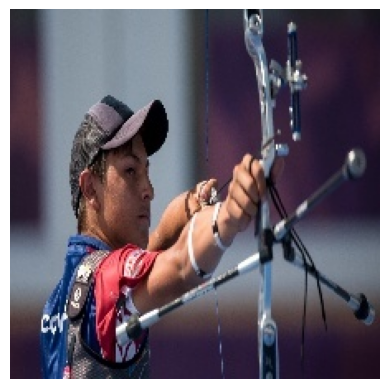

In [4]:
# Lets visualize some images

image1_path = "/content/drive/MyDrive/MY_PROJECT/DL Project/sports-classification/train/archery/003.jpg"
image1 = image.imread(image1_path)
plt.imshow(image1)
plt.axis(False)
plt.show()

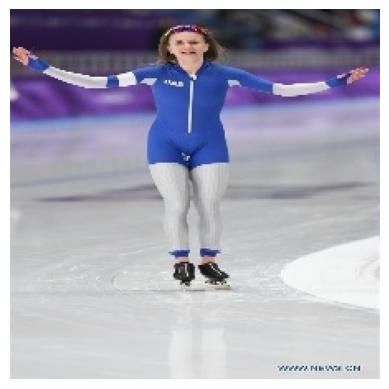

In [5]:
image2_path = "/content/drive/MyDrive/MY_PROJECT/DL Project/sports-classification/train/figure skating women/005.jpg"
image2 = image.imread(image2_path)
plt.imshow(image2)
plt.axis(False)
plt.show()

In [6]:
# All images have the shape of (224, 224, 3)

image1.shape, image2.shape

((224, 224, 3), (224, 224, 3))

In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import mobilenet_v2

In [8]:
# Get the train, test and validation data

train_data_path = "/content/drive/MyDrive/MY_PROJECT/DL Project/sports-classification/train"
test_data_path = "/content/drive/MyDrive/MY_PROJECT/DL Project/sports-classification/test"
valid_data_path = "/content/drive/MyDrive/MY_PROJECT/DL Project/sports-classification/valid"

train_data = image_dataset_from_directory(
    directory=train_data_path,
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    class_names=sports_list,
    seed=39,
    image_size=(224, 224),
    batch_size=32
)

test_data = image_dataset_from_directory(
    directory=test_data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=sports_list,
    image_size=(224, 224),
    batch_size=32
)

valid_data = image_dataset_from_directory(
    directory=valid_data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=sports_list,
    shuffle=True,
    seed=39,
    image_size=(224, 224),
    batch_size=32
)

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [9]:
train_data.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=422>

In [10]:
# np.ceil(500/32)

test_data.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=16>

In [11]:
valid_data.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=16>

In [12]:
img, lab = next(train_data.as_numpy_iterator())
print(f"Images shape is {img.shape}")
print(f"Labels shape is {lab.shape}")
print(lab)

Images shape is (32, 224, 224, 3)
Labels shape is (32, 100)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
img, lab = next(train_data.as_numpy_iterator())
lab

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

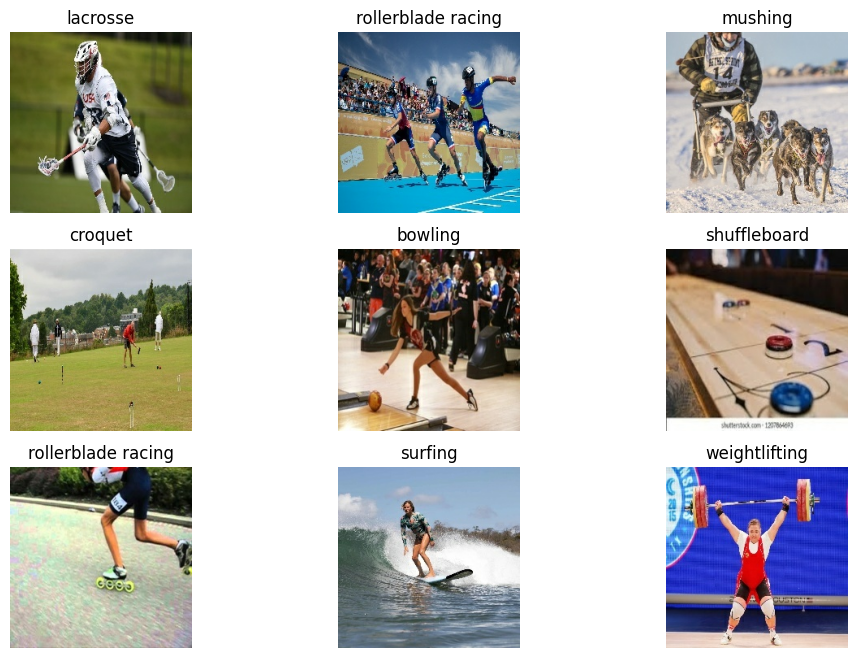

In [14]:
# Let's visualize some images from training data

n_images = 9

plt.figure(figsize=(12, 8))
for i, (image, label) in enumerate(train_data.unbatch().as_numpy_iterator(), start=1):
    plt.subplot(3, 3, i)
    plt.imshow(image.astype("int16"))
    plt.title(sports_list[np.argmax(label)])
    plt.axis(False)

    if (i == n_images):
        break
plt.show()

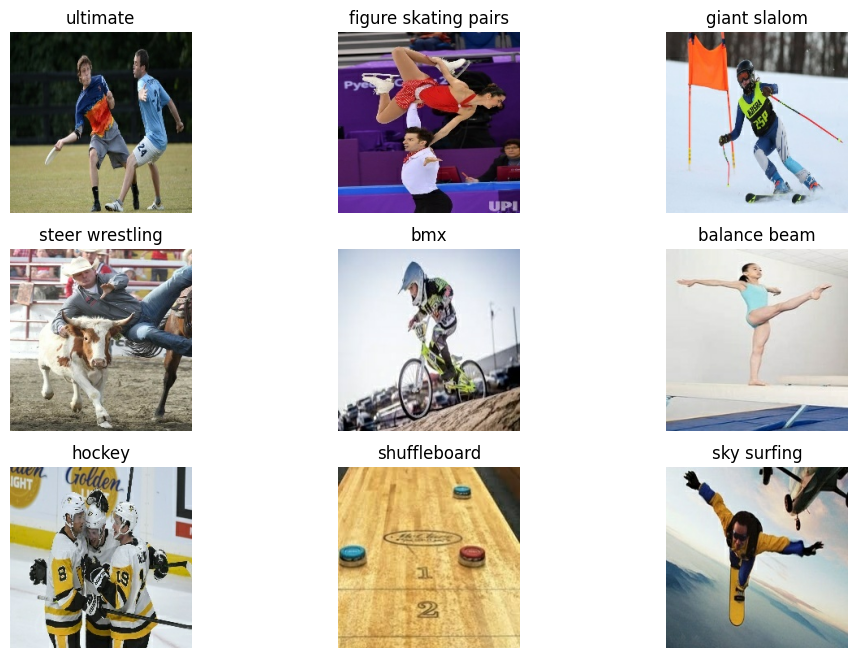

In [15]:
 n_images = 9

 plt.figure(figsize=(12, 8))
 for i, (image, label) in enumerate(train_data.unbatch().take(n_images).as_numpy_iterator(), start=1):
     plt.subplot(3, 3, i)
     plt.imshow(image.astype("int16"))
     plt.title(sports_list[np.argmax(label)])
     plt.axis(False)

     if (i == n_images):
         break
 plt.show()

In [16]:
# Get the pre-trained model for finetuning

mobilenet = mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

for layer in mobilenet.layers:
    layer.trainable = False

# mobilenet.summary()

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
# Converting the preproces_input function to a custom keras layer so that we can include it in sequential model

from tensorflow.keras.layers import Layer

class MobileNetPreprocessInput(Layer):
    def __init__(self):
        super().__init__()
    def call(self, X):
        return mobilenet_v2.preprocess_input(X)

In [18]:
# Create the model

model = Sequential([
    Input((224, 224, 3)),
    MobileNetPreprocessInput(),
    mobilenet,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(512, activation="relu"),
    Dropout(0.2),
    Dense(100, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobile_net_preprocess_inpu  (None, 224, 224, 3)       0         
 t (MobileNetPreprocessInpu                                      
 t)                                                              
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               6

In [19]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.F1Score(average='macro')
    ]
)

In [20]:
model.fit(
    train_data,
    epochs=10,
    validation_data=valid_data,
    verbose=1
)

Epoch 1/10
422/422 [==============================] - 2859s 7s/step - loss: 1.4219 - accuracy: 0.6342 - f1_score: 0.6336 - val_loss: 0.4541 - val_accuracy: 0.8740 - val_f1_score: 0.8707
Epoch 2/10
422/422 [==============================] - 49s 114ms/step - loss: 0.5127 - accuracy: 0.8455 - f1_score: 0.8446 - val_loss: 0.3218 - val_accuracy: 0.8840 - val_f1_score: 0.8817
Epoch 3/10
422/422 [==============================] - 49s 114ms/step - loss: 0.3516 - accuracy: 0.8908 - f1_score: 0.8909 - val_loss: 0.3292 - val_accuracy: 0.8960 - val_f1_score: 0.8946
Epoch 4/10
422/422 [==============================] - 50s 114ms/step - loss: 0.2631 - accuracy: 0.9162 - f1_score: 0.9165 - val_loss: 0.2727 - val_accuracy: 0.9040 - val_f1_score: 0.9057
Epoch 5/10
422/422 [==============================] - 49s 114ms/step - loss: 0.2151 - accuracy: 0.9287 - f1_score: 0.9288 - val_loss: 0.2562 - val_accuracy: 0.9140 - val_f1_score: 0.9141
Epoch 6/10
422/422 [==============================] - 49s 115ms/st

In [21]:
model.evaluate(test_data)

16/16 [==============================] - 124s 3s/step - loss: 0.2505 - accuracy: 0.9180 - f1_score: 0.9129


[0.2504524886608124, 0.9179999828338623, 0.9128676056861877]

In [22]:
y_true = []
test_images = []
for image, label in test_data.unbatch().as_numpy_iterator():
    y_true.append(np.argmax(label))
    test_images.append(image.tolist())

y_pred = model.predict(np.array(test_images))

16/16 [==============================] - 2s 44ms/step


In [23]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([46, 27, 98, 76, 53, 30, 41,  7, 57, 45, 92, 60,  4, 15, 11, 59,  6,
       39, 78, 81, 65, 41, 67, 32, 37,  8, 28, 26, 10, 88, 29, 11, 47, 93,
       59, 84, 17, 65, 67, 90,  5, 69, 94, 90, 75, 60, 76, 21, 54,  9, 94,
       67,  2, 58, 72, 77, 74, 27, 33, 17,  0, 73, 90, 79, 91, 61, 92,  6,
       97,  7, 89, 95, 18, 86, 66, 25, 16, 81, 82, 51, 87, 72, 15, 91, 86,
       16, 38, 98, 71,  3, 35, 21, 57, 19, 16, 36, 22, 21, 13, 43, 71, 73,
       26, 38, 96, 53, 74, 99, 15, 61, 24, 22, 35, 48, 21, 99, 64, 30, 30,
       43, 31, 93, 48, 52, 74, 50, 58, 44, 68, 13, 62, 15, 62, 28, 75, 68,
       76, 72, 35, 30, 32,  3, 18,  0, 83, 96, 23, 87,  1, 53, 58, 78, 45,
       25, 61, 21, 92, 98, 83,  8, 61, 36, 29, 16, 64, 60, 29, 97, 46, 96,
       52, 13, 12, 84,  0, 54, 80, 26, 85, 20, 55, 52, 97,  5, 35, 75, 75,
        4, 62, 70, 20, 50, 33, 68, 73, 39, 40, 62, 34, 65, 33, 93, 45, 17,
       57, 85,  7,  8,  8, 28, 95, 91, 65,  2, 41, 88,  7, 44, 67,  9, 49,
       32, 70, 86, 34, 22

In [24]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

print(f"The accuracy is {accuracy_score(y_true, y_pred)}")
print("The f1 score is ", f1_score(y_true, y_pred, average="macro"))

The accuracy is 0.918
The f1 score is  0.9128676323676324


In [25]:
print("Classification report")
print(classification_report(y_true, y_pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.80      0.80      0.80         5
           3       0.83      1.00      0.91         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       0.83      1.00      0.91         5
           9       0.80      0.80      0.80         5
          10       0.71      1.00      0.83         5
          11       1.00      1.00      1.00         5
          12       1.00      0.40      0.57         5
          13       0.83      1.00      0.91         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       0.83      1.00      0.91         5
     

Confusion matrix


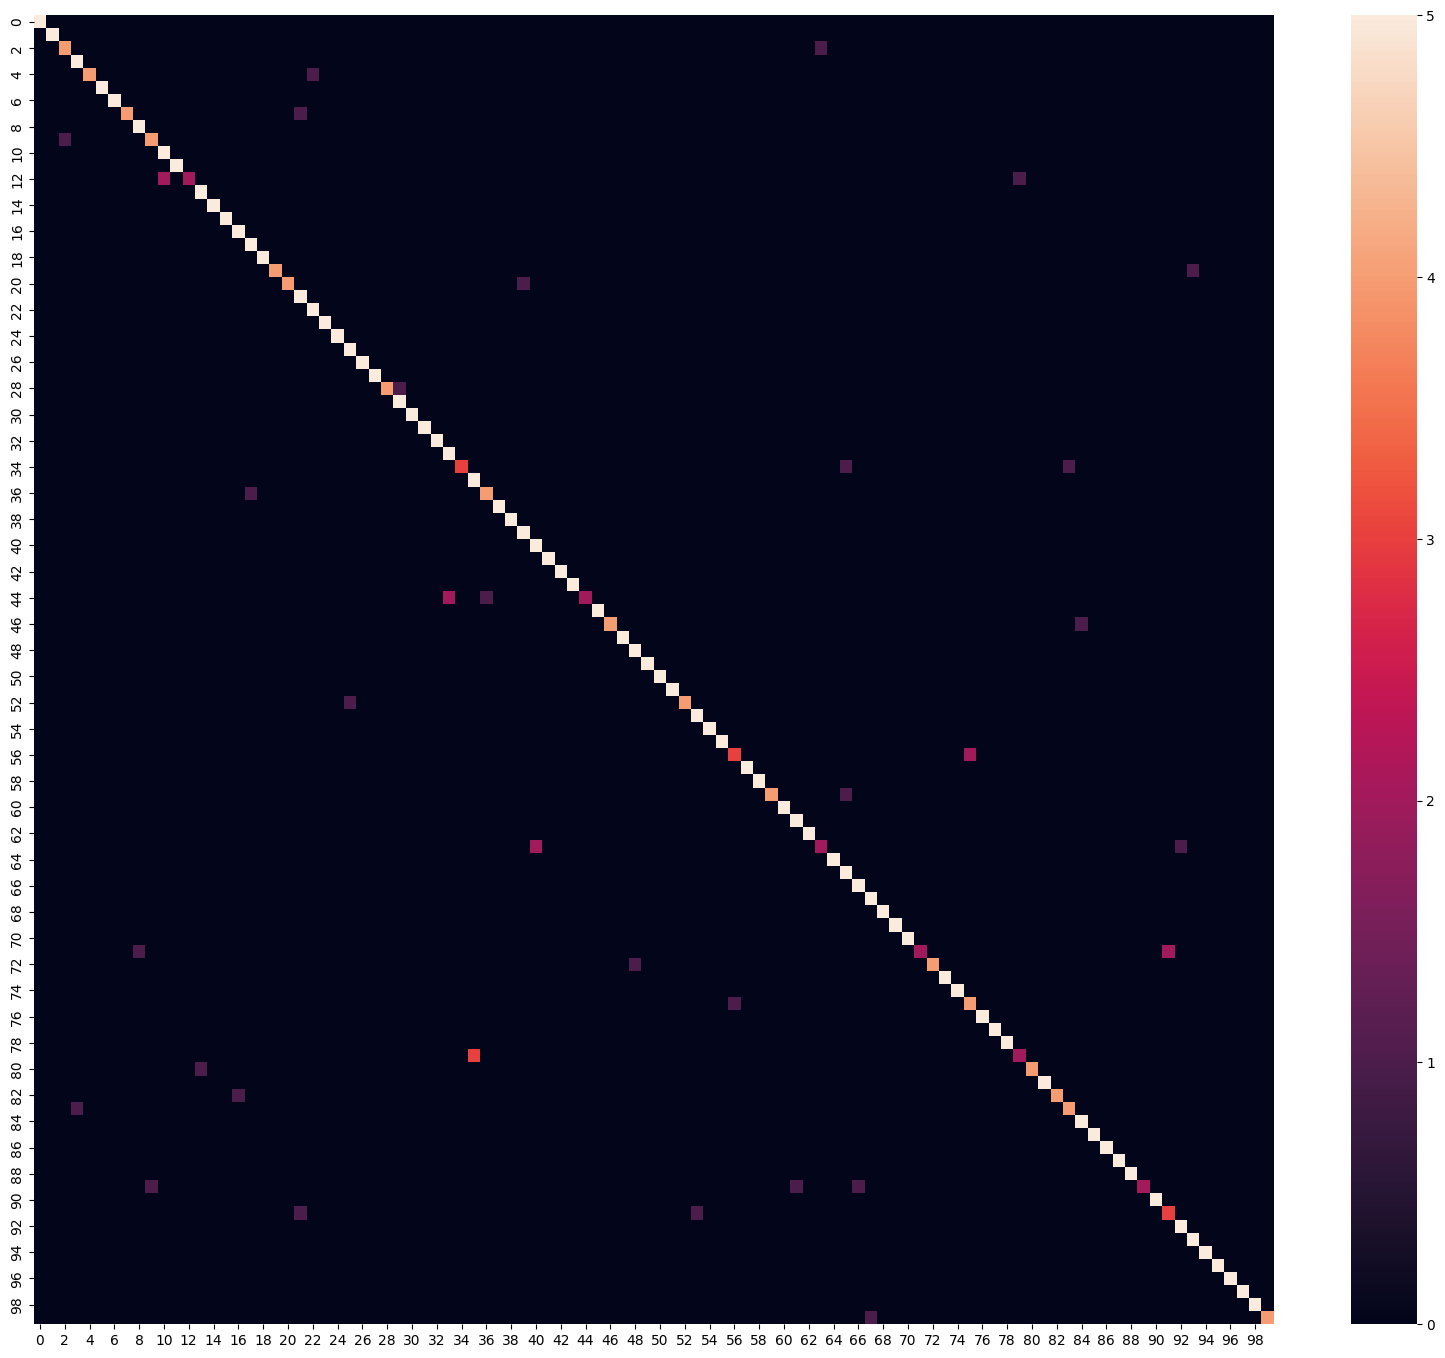

In [26]:
print("Confusion matrix")
conf_matrix = confusion_matrix(y_true, y_pred)

import seaborn as sns

plt.figure(figsize=(20, 17))
sns.heatmap(conf_matrix)
plt.show()

1/1 [==============================] - 2s 2s/step


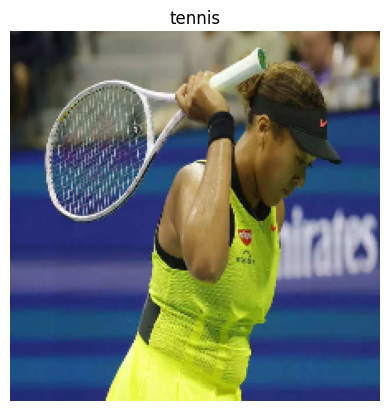

In [27]:
import urllib.request

url = 'https://img.etimg.com/thumb/width-640,height-480,imgsize-78314,resizemode-75,msid-85943078/news/sports/why-does-playing-tennis-make-so-many-pros-miserable/osaka-reuters.jpg'

urllib.request.urlretrieve(url, 'image.jpg')

img = cv2.imread('image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))

prediction = model.predict(np.expand_dims(img, 0))

plt.imshow(img)
plt.axis(False)
plt.title(sports_list[np.argmax(prediction)])
plt.show()

1/1 [==============================] - 0s 41ms/step


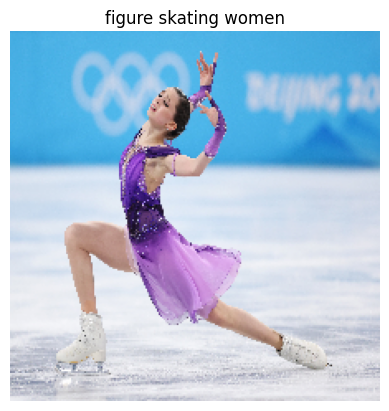

In [28]:
import urllib.request

url = 'https://media.npr.org/assets/img/2022/02/16/gettyimages-1370717592-bb946b1ddb3d85a3279e7911fa7af739b924ca10.jpg'

urllib.request.urlretrieve(url, 'image.jpg')

img = cv2.imread('image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))

prediction = model.predict(np.expand_dims(img, 0))

plt.imshow(img)
plt.axis(False)
plt.title(sports_list[np.argmax(prediction)])
plt.show()

1/1 [==============================] - 0s 115ms/step


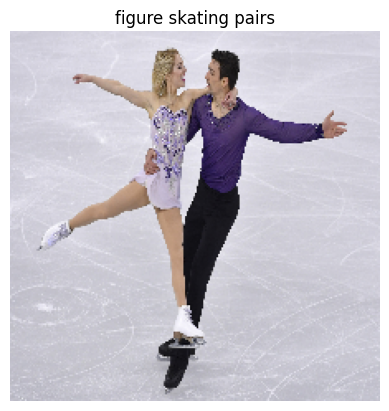

In [30]:
import urllib.request

url = 'https://api.time.com/wp-content/uploads/2018/02/real-life-figure-skating-ice-dancing-couples-2018-olympics-pyeong-chang.jpg'

urllib.request.urlretrieve(url, 'image.jpg')

img = cv2.imread('image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))

prediction = model.predict(np.expand_dims(img, 0))

plt.imshow(img)
plt.axis(False)
plt.title(sports_list[np.argmax(prediction)])
plt.show()